In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uom190346a_sleep_health_and_lifestyle_dataset_path = kagglehub.dataset_download('uom190346a/sleep-health-and-lifestyle-dataset')

print('Data source import complete.')

Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv


# **Importación de Librerias**


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder ,RobustScaler,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold,cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# **Lectura del datos**

In [ ]:
df = pd.read_csv('/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv')

# **EDA**

 Esta sección tiene como objetivo conocer los datos con los que se trabajaran, para poder visualizarlos y manipularlos ccon la finalidad de determinar si existe una causalidad entre el padecemiento de insomnio y/o apnea y las otras variables presentes en el dataset.

In [ ]:
df.head(5) # Vista rápida de los datos

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [ ]:
df.shape # Tamaño de la base de datos

(374, 13)

In [ ]:
df.dtypes # Visualización del tipo de datos contenidos en cada columna

,0
Person ID,int64
Gender,object
Age,int64
Occupation,object
Sleep Duration,float64
Quality of Sleep,int64
Physical Activity Level,int64
Stress Level,int64
BMI Category,object
Blood Pressure,object


In [ ]:
df.isna().sum( ) # Verificación de datos/valores nulos


,0
Person ID,0
Gender,0
Age,0
Occupation,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
BMI Category,0
Blood Pressure,0


*   Del conteto de datos faltantes, se observa que la columna "Sleep Disorder" contiene 219 datos faltantes, visualizados como "NaN". Su tratamiento se hará más adelante




In [ ]:
df.describe() # Resumen de métricas de estadística descriptiva de las variables numéricas del DataFrame

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


In [ ]:
columns = [column for column in df.columns if column!='Person ID'] # Exclusión de variables no útiles para el análisis

In [ ]:
for column in columns:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}': {unique_values}")  # Visualización de los valores únicos contenidos en cada columna

Unique values in 'Gender': ['Male' 'Female']
Unique values in 'Age': [27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 48 49 50 51 52
 53 54 55 56 57 58 59]
Unique values in 'Occupation': ['Software Engineer' 'Doctor' 'Sales Representative' 'Teacher' 'Nurse'
 'Engineer' 'Accountant' 'Scientist' 'Lawyer' 'Salesperson' 'Manager']
Unique values in 'Sleep Duration': [6.1 6.2 5.9 6.3 7.8 6.  6.5 7.6 7.7 7.9 6.4 7.5 7.2 5.8 6.7 7.3 7.4 7.1
 6.6 6.9 8.  6.8 8.1 8.3 8.5 8.4 8.2]
Unique values in 'Quality of Sleep': [6 4 7 5 8 9]
Unique values in 'Physical Activity Level': [42 60 30 40 75 35 45 50 32 70 80 55 90 47 65 85]
Unique values in 'Stress Level': [6 8 7 4 3 5]
Unique values in 'BMI Category': ['Overweight' 'Normal' 'Obese' 'Normal Weight']
Unique values in 'Blood Pressure': ['126/83' '125/80' '140/90' '120/80' '132/87' '130/86' '117/76' '118/76'
 '128/85' '131/86' '128/84' '115/75' '135/88' '129/84' '130/85' '115/78'
 '119/77' '121/79' '125/82' '135/90' '122/80' '142/92' '140/95

# Tratamiento de los valores faltantes en la columna "Sleep Disorder".


In [ ]:
# Remplazo de valores  NaN en 'Sleep Disorder' con 'No Disorder'
df['Sleep Disorder'].fillna('No Disorder', inplace=True)

In [ ]:
# Conteo de valores de 'Sleep Disorder'
sleep_disorder_counts = df['Sleep Disorder'].value_counts() # verificación del remplazo correcto de valores

print("Value counts of 'Sleep Disorder':")
print(sleep_disorder_counts)
print(sleep_disorder_counts.sum())


Value counts of 'Sleep Disorder':
Sleep Disorder
No Disorder    219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64
374


In [ ]:

df['BMI Category']=df['BMI Category'].replace({'Normal':'Normal Weight'})
df['BMI Category'].value_counts()



,count
BMI Category,
Normal Weight,216
Overweight,148
Obese,10


In [ ]:
# bmi_counts = df['BMI Category'].value_counts()
fig =px.histogram(data_frame=df, x = 'BMI Category', color = 'Sleep Disorder', title='Bar Chart of BMI Category Counts')
fig.show()





*   Personas con obesidad padecen apnea del sueño e insomnio
*   Muy pocas personas con sobrepeso no padecen trastornos del sueño.
*   Muy pocas personas con peso normal padecen trastornos del sueño.




In [ ]:
fig = px.histogram(data_frame=df, x = 'Quality of Sleep', color = 'Sleep Disorder', title='Quality of sleep associated with sleep disorders')
fig.show()

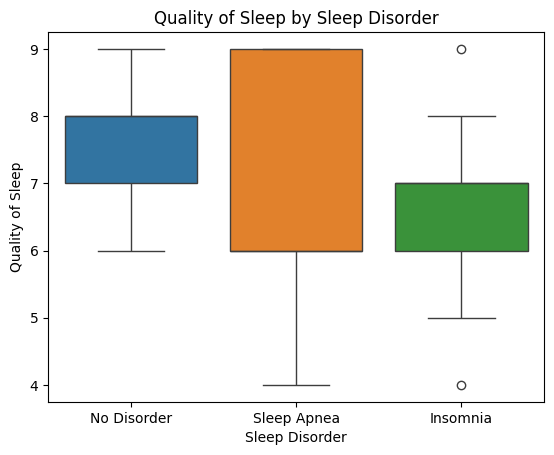

In [ ]:
sns.boxplot(x='Sleep Disorder', y='Quality of Sleep',hue='Sleep Disorder',data=df)
plt.title('Quality of Sleep by Sleep Disorder')
plt.xlabel('Sleep Disorder')
plt.ylabel('Quality of Sleep')
plt.show()



*   Los trastornos del sueño afectan la calidad del descanso; en particular, las personas con insomnio suelen experimentar una calidad de sueño significativamente reducida




In [ ]:
fig = px.histogram(data_frame=df, x = 'Occupation', color = 'Sleep Disorder', title='Frequency of sleep disorders by ocupation')
fig.show()



*   Quienes trabajan en enfermería, docencia, ventas o representación comercial son más propensos a experimentar trastornos del sueño




In [ ]:
fig = px.histogram(data_frame=df, x = 'Gender', color = 'Sleep Disorder', title='Frequency of sleep disorders by Gender')
fig.show()



*   La apnea del sueño es más frecuente en personas de género femenino, mientras que el insomnio se presenta con mayor frecuencia en personas de género masculino

In [ ]:


fig=px.histogram(x='Age',color="Sleep Disorder",data_frame=df,title='Frequency of sleep disorders by age')
fig.show()

*  A partir de los 42 años aumenta la incidencia de los trastornos del sueño(apnea e insomnio)



In [ ]:
fig = px.histogram(data_frame=df, x = 'Sleep Duration', color = 'Sleep Disorder', title='Relationship between Sleep Duration and Sleep Duration')
fig.show()



*   Dormir entre 7-8.5 horas diarias mejora la calidad del sueño

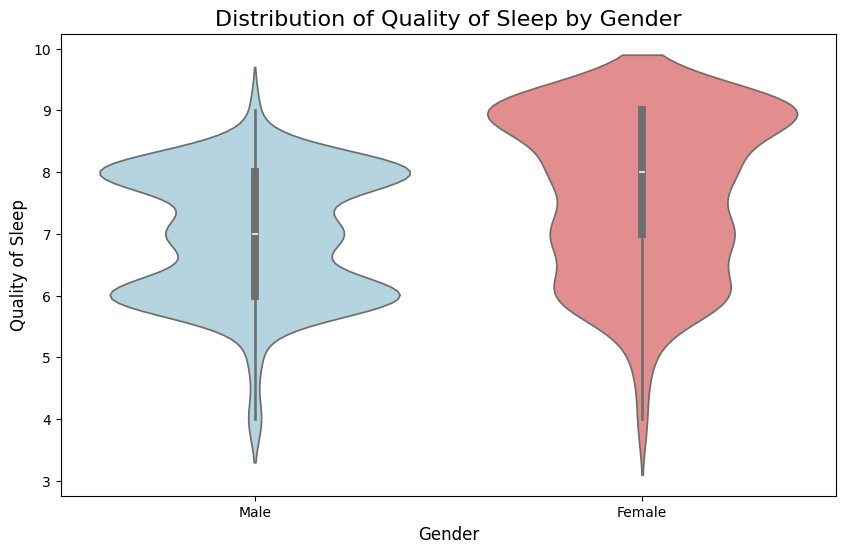

In [ ]:
color_palette = {'Male': 'lightblue', 'Female': 'lightcoral'}
plt.figure(figsize=(10, 6))
sns.violinplot(x='Gender', y='Quality of Sleep', data=df, palette=color_palette)
plt.title('Distribution of Quality of Sleep by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Quality of Sleep', fontsize=12)
plt.show()

In [ ]:
df['Gender'].value_counts() # Clase balanceada

,count
Gender,
Male,189
Female,185


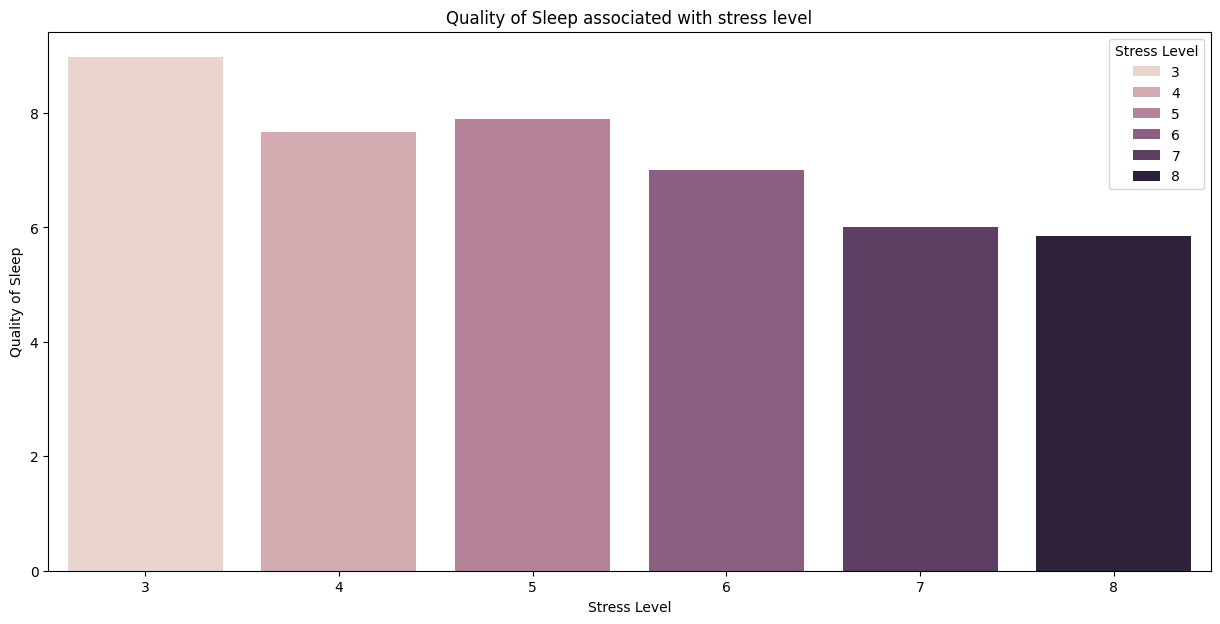

In [ ]:
plt.figure(figsize=(15,7))



sns.barplot(x='Stress Level', y='Quality of Sleep', data=df,hue="Stress Level",errorbar=None)
plt.title('Quality of Sleep associated with stress level')
plt.xlabel('Stress Level')
plt.ylabel('Quality of Sleep')
plt.show()



*   Los niveles de estrés influyen en la calidad del sueño. Niveles altos de estres disminuyen la calidad del sueño



#   **Separación de la variable "Blood Pressure" en dos columnas: *Sistólica* y *Diastólica***


In [ ]:
df = pd.concat([df, df['Blood Pressure'].str.split('/', expand=True)], axis=1).drop('Blood Pressure', axis=1)
df = df.rename(columns={0: 'Systolic', 1: 'Diastolic'})

In [ ]:
df['Systolic'] = df['Systolic'].astype(float)
df['Diastolic'] = df['Diastolic'].astype(float)

In [ ]:
# Separación de variables categóricas y numéricas
numeric_features = ['Age', 'Sleep Duration',
                    'Physical Activity Level',
                    'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic','Stress Level','Quality of Sleep']

categorical_features = ['Occupation', 'Gender', 'BMI Category']

#   **Pre-procesamiento**
En el pre-procesamiento, las variables categóricas se codificaran númericamente para su posterior uso en los modelos de clasificación.


In [ ]:
# Tranformacion de la varible objetivo de variable categórica a numérica
label_encoder = LabelEncoder()
df['Sleep Disorder Encoder'] = label_encoder.fit_transform(df['Sleep Disorder'])
# Tranformacion de la varible objetivo de variable categórica a numérica


In [ ]:
#Observamos como se ven los valores codificados asocidos a las clases no codificadas
print(df[['Sleep Disorder Encoder', 'Sleep Disorder']].head())



   Sleep Disorder Encoder Sleep Disorder
0                       1    No Disorder
1                       1    No Disorder
2                       1    No Disorder
3                       2    Sleep Apnea
4                       2    Sleep Apnea


Codificación dada por LabelEncoder:


*   1=No Disorder
*   2=Sleep Apnea
*   3=Insomnio



In [ ]:
df.drop(columns=['Person ID'],inplace = True)

In [ ]:
df.head() # Visualizamos el DataFrame

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic,Sleep Disorder Encoder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,No Disorder,126.0,83.0,1
1,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,No Disorder,125.0,80.0,1
2,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,No Disorder,125.0,80.0,1
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140.0,90.0,2
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140.0,90.0,2


In [ ]:
numeric_features = ['Age', 'Sleep Duration','Quality of Sleep','Physical Activity Level','Stress Level',
                    'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

categorical_features = ['Occupation','Gender', 'BMI Category']

In [ ]:
categorical_features = ['Occupation','Gender', 'BMI Category']

# Creamos una función para tranformar las variables categóricas a variables numéricas
for cat in categorical_features:
  #cargamos el codificador
    encoder = OneHotEncoder(sparse_output=False)
  #Codificamos las columnas
    encoded_catFeat = encoder.fit_transform(df[[cat]])
  #Obtenemos el df
    encoded_df = pd.DataFrame(encoded_catFeat, columns=encoder.get_feature_names_out([cat]))
    #concatenamos las columnas con el dataframe original
    df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [ ]:
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,...,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,Gender_Female,Gender_Male,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


                                  Age  Sleep Duration  Quality of Sleep  \
Age                              1.00            0.34              0.47   
Sleep Duration                   0.34            1.00              0.88   
Quality of Sleep                 0.47            0.88              1.00   
Physical Activity Level          0.18            0.21              0.19   
Stress Level                    -0.42           -0.81             -0.90   
Heart Rate                      -0.23           -0.52             -0.66   
Daily Steps                      0.06           -0.04              0.02   
Systolic                         0.61           -0.18             -0.12   
Diastolic                        0.59           -0.17             -0.11   
Sleep Disorder Encoder           0.23            0.18              0.18   
Occupation_Accountant           -0.10           -0.01              0.16   
Occupation_Doctor               -0.53           -0.10             -0.27   
Occupation_Engineer      

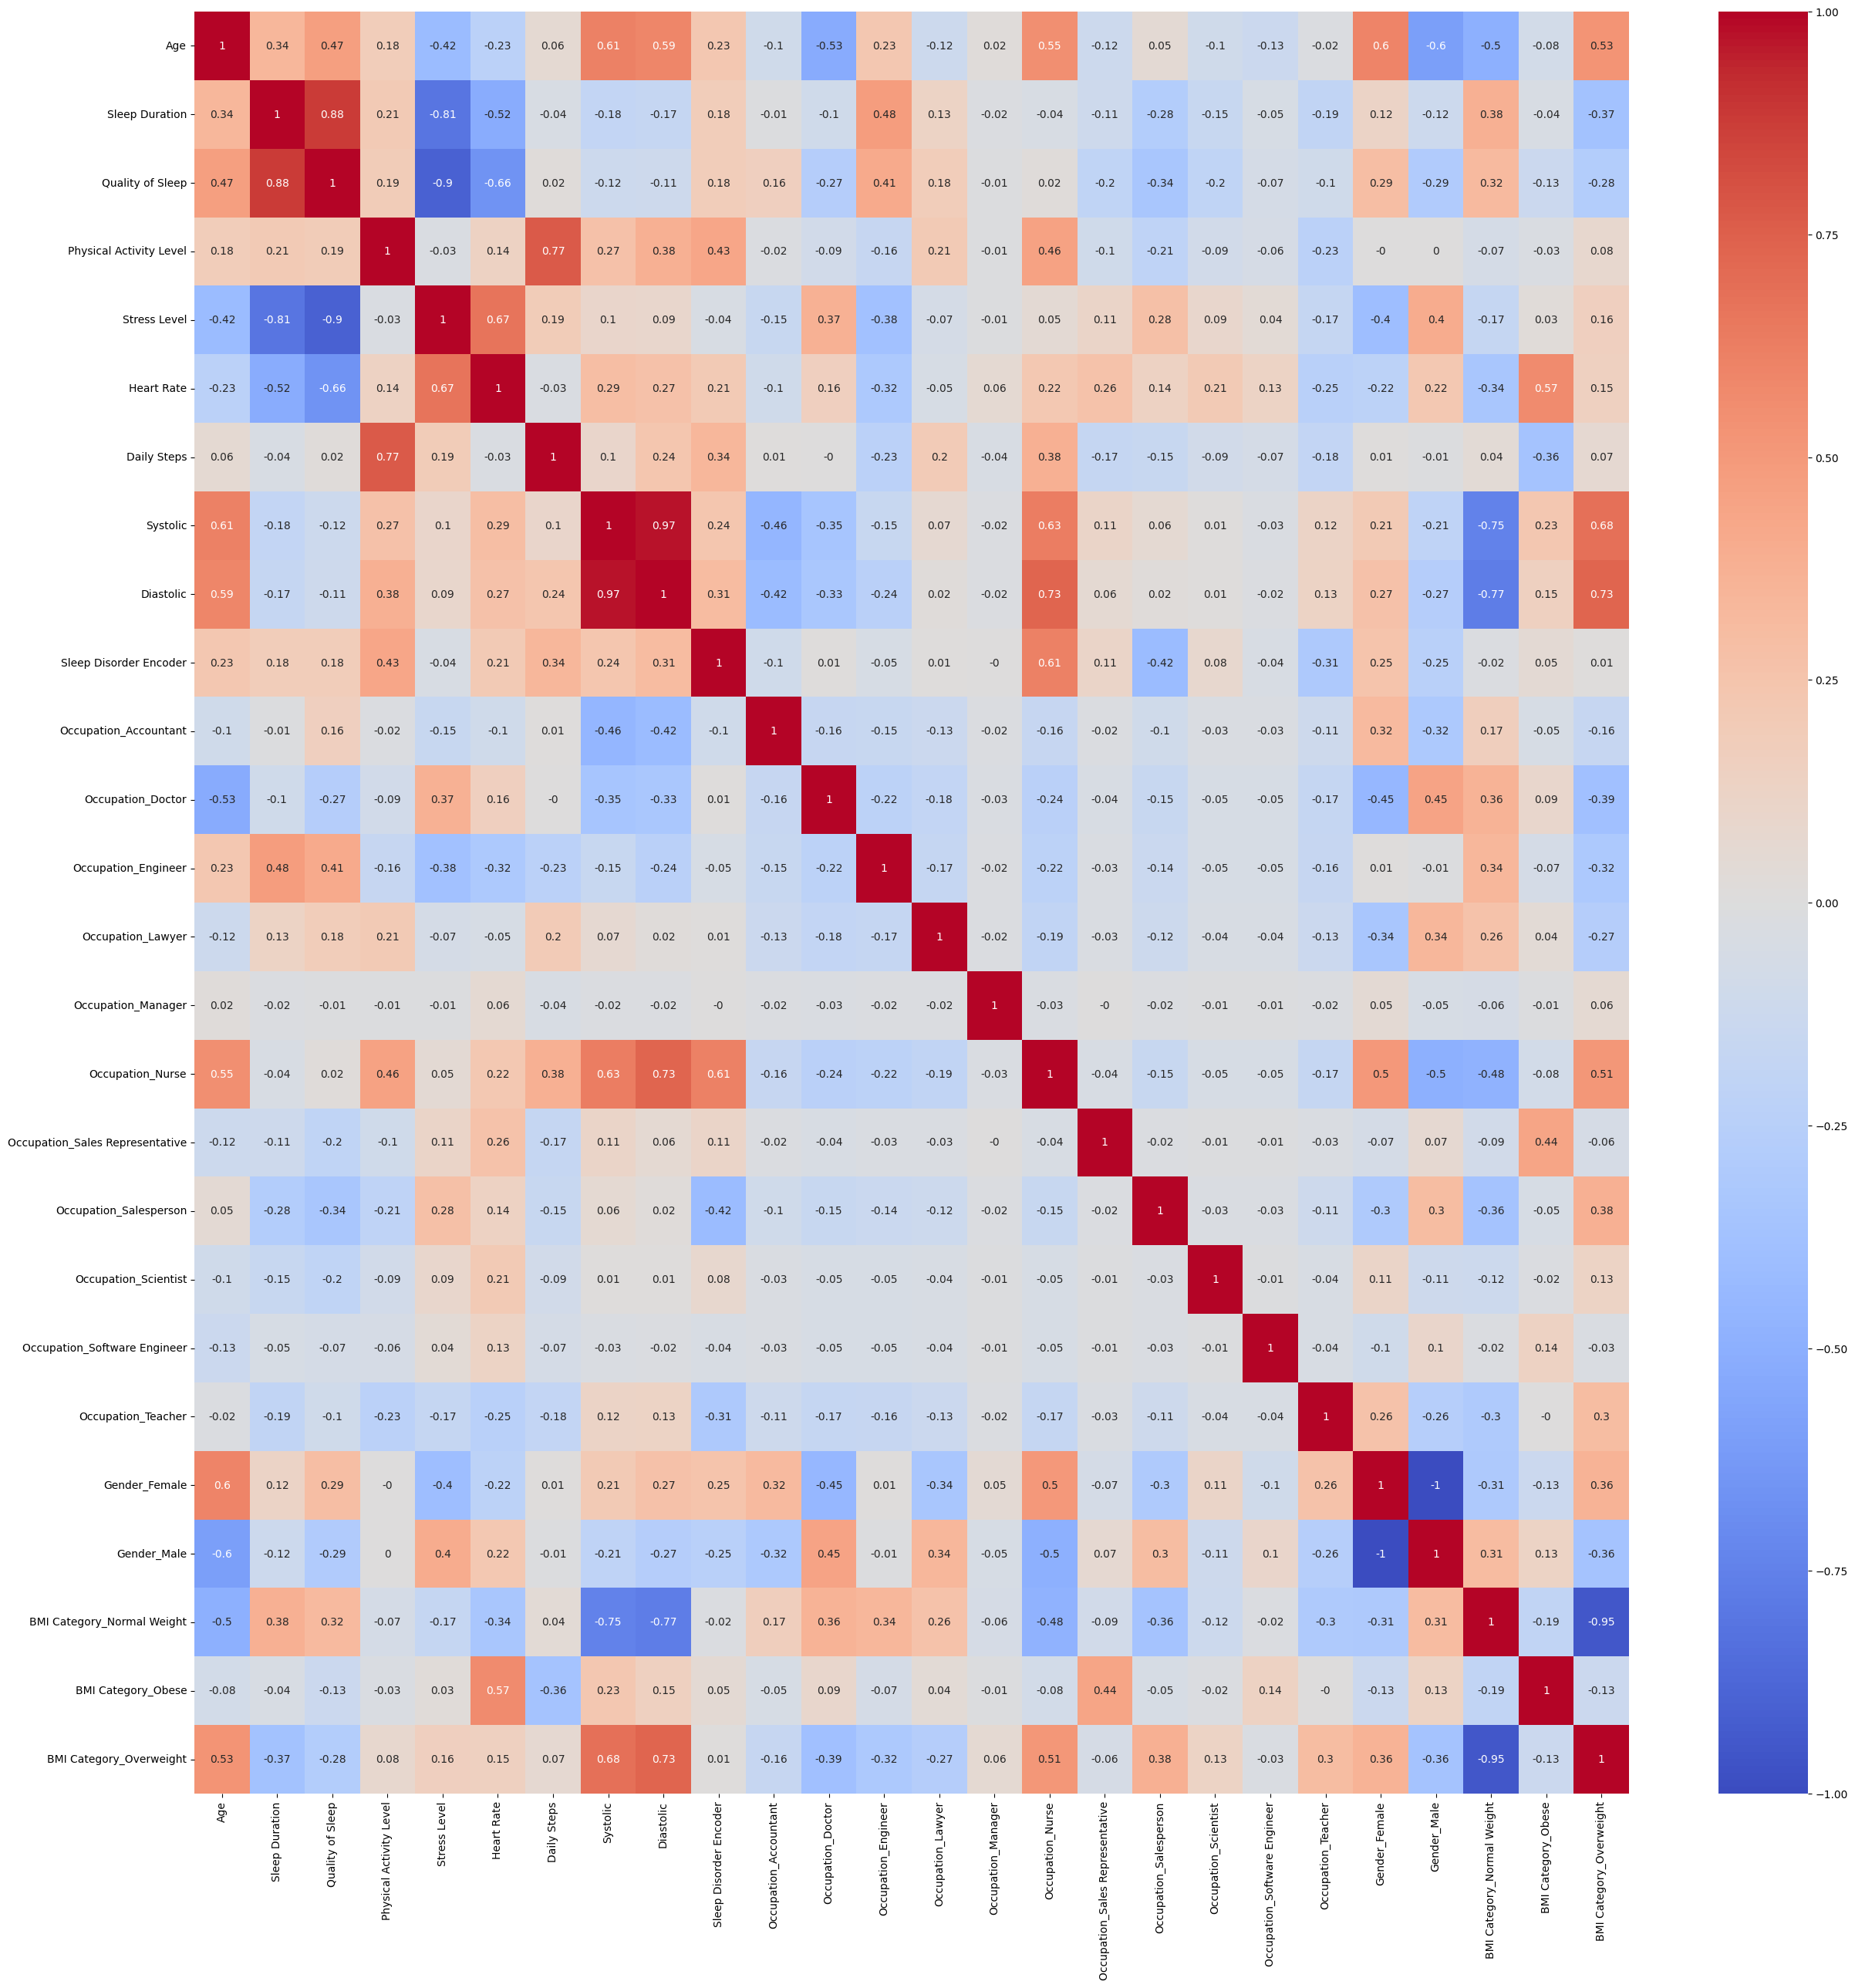

In [ ]:
# Visualización de la correlación entre las variables numéricas y la varible de interes "Sleep Disorder".
# La Matriz de correlación nos permitirá seleccionar las variables numérica a partir de las cuales se puede determinar si una persona
# padece o no trastornos del sueño.

columnas = df.select_dtypes(include=['number'])

matriz = columnas.corr()

matriz = matriz.round(2)

print(matriz)

plt.figure(figsize=(30,30))
sns.heatmap(matriz, annot=True, cmap='coolwarm')
plt.show()



La matriz de correlación nos deja ver que podemos prescindir de las siguientes variables:

*   Calidad del sueño
*   Nivel de estres
*   Duración del sueño
*   Índice de masa corporal


 Por lo que nos quedaríamos con las siguientes Variables:

 * Edad
 * Ocupación
 * Presión diastólica
 * Presión sistólica
 * Género
 * Pasos diarios
 * Nivel de actividad física
 * Frecuencia Cardiaca

#  **Modelado**

Modelos de clasificación multivariable para determinar si se padece algún rastorno del sueño o no.

In [ ]:
# Nuevamente separamos las variables categóricas y numéricas que tiene correlación "fuerte" con la variable de interes
Numerical_features_2 = ['Age','Physical Activity Level', 'Daily Steps', 'Diastolic','Systolic']

Categorical_features_2 = ['Occupation','Gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), Numerical_features_2),
        ('cat', OneHotEncoder(drop='first',sparse_output =True, handle_unknown='ignore'), Categorical_features_2)
    ])

In [ ]:
X = df.drop(columns=['Sleep Disorder Encoder'])
y = df['Sleep Disorder Encoder']




In [ ]:
X_preprocessed = preprocessor.fit_transform(X)


In [ ]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Perform SMOTE oversampling
X_smote, y_smote = smote.fit_resample(X_preprocessed, y)
X_smote.shape

(657, 16)

In [ ]:
# Splitting the data into training and testing sets (e.g., 75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=60)

# **MODELO 1- Regresión logística**

Accuracy: 0.9151515151515152
Precision: 0.9157445966012209
Recall: 0.9151515151515152
F1-score: 0.9151049782028134
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        51
           1       0.89      0.94      0.92        54
           2       0.93      0.90      0.92        60

    accuracy                           0.92       165
   macro avg       0.92      0.92      0.92       165
weighted avg       0.92      0.92      0.92       165

Confusion Matrix:
[[46  4  1]
 [ 0 51  3]
 [ 4  2 54]]


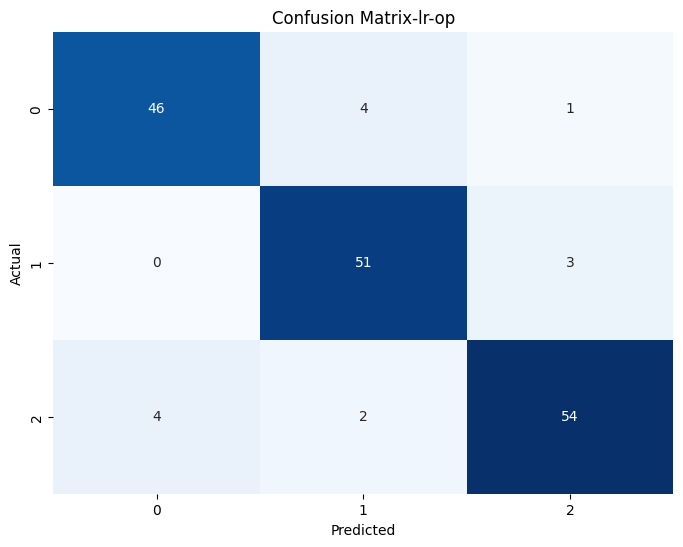

In [ ]:
# Initialize Logistic Regression classifier
model_lr = LogisticRegression()

# Fit the model on the training data
model_lr.fit(X_train, y_train)

# Predict on the test data
y_pred_lr = model_lr.predict(X_test)

# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy_lr}')
print(f'Precision: {precision_lr}')
print(f'Recall: {recall_lr}')
print(f'F1-score: {f1_lr}')

# Generate classification report
print(classification_report(y_test, y_pred_lr))

# Generate confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print('Confusion Matrix:')
print(cm_lr)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix-lr-op')
plt.show()




*   Accuracy= 0.92




# **Clasificador XGBoost**

Accuracy: 0.9636363636363636
Precision: 0.9647008728975941
Recall: 0.9636363636363636
F1-score: 0.9637665915351866
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        51
           1       0.93      0.96      0.95        54
           2       0.97      0.98      0.98        60

    accuracy                           0.96       165
   macro avg       0.97      0.96      0.96       165
weighted avg       0.96      0.96      0.96       165

Confusion Matrix:
[[48  3  0]
 [ 0 52  2]
 [ 0  1 59]]


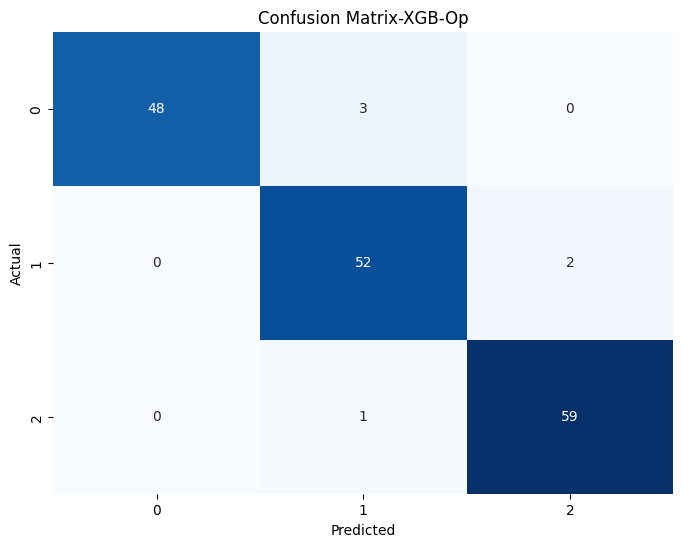

In [ ]:
# Initialize XGBoost classifier (assuming classification task)
model_xgb = xgb.XGBClassifier()

# Fit the model on the training data
model_xgb.fit(X_train, y_train)

# Predict on the test data
y_pred = model_xgb.predict(X_test)
# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred)
precision_xgb = precision_score(y_test, y_pred, average='weighted')
recall_xgb = recall_score(y_test, y_pred, average='weighted')
f1_xgb = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy_xgb}')
print(f'Precision: {precision_xgb}')
print(f'Recall: {recall_xgb}')
print(f'F1-score: {f1_xgb}')

# Generate classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix-XGB-Op')
plt.show()




*   Accuracy=0.96




# **Modelo Cross Eval XGB**

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(xgb_model, X_smote, y_smote, cv=cv, scoring='accuracy')

In [ ]:
scores

array([0.93939394, 0.90909091, 0.9389313 , 0.90076336, 0.89312977])

# **Clasificador gradient boosting**

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        51
           1       0.95      0.96      0.95        54
           2       0.95      0.98      0.97        60

    accuracy                           0.96       165
   macro avg       0.97      0.96      0.96       165
weighted avg       0.96      0.96      0.96       165



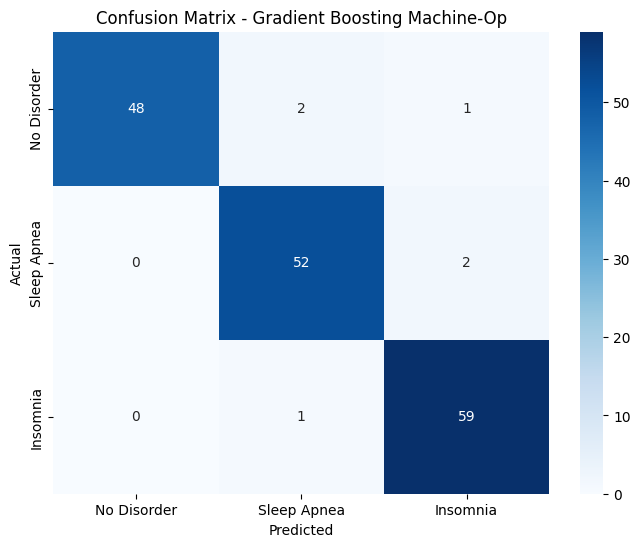

Accuracy: 0.9636
Precision: 0.9646
Recall: 0.9636
F1 Score: 0.9637


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize GBM classifier
gbm_clf = GradientBoostingClassifier(random_state=42)

# Train the model
gbm_clf.fit(X_train, y_train)

# Predictions
y_pred = gbm_clf.predict(X_test)

# Calculate metrics
accuracy_gbm = accuracy_score(y_test, y_pred)
precision_gbm = precision_score(y_test, y_pred, average='weighted')
recall_gbm = recall_score(y_test, y_pred, average='weighted')
f1_gbm = f1_score(y_test, y_pred, average='weighted')

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['No Disorder', 'Sleep Apnea', 'Insomnia'], yticklabels=['No Disorder', 'Sleep Apnea', 'Insomnia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting Machine-Op')
plt.show()

# Display metrics
print(f"Accuracy: {accuracy_gbm:.4f}")
print(f"Precision: {precision_gbm:.4f}")
print(f"Recall: {recall_gbm:.4f}")
print(f"F1 Score: {f1_gbm:.4f}")


# **Clasificador de K-vecinos cercanos**

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        51
           1       0.91      0.94      0.93        54
           2       0.94      0.97      0.95        60

    accuracy                           0.95       165
   macro avg       0.95      0.94      0.95       165
weighted avg       0.95      0.95      0.95       165



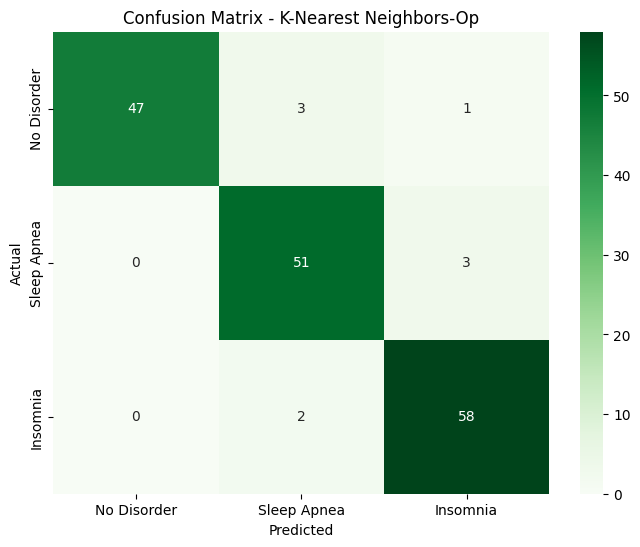

Accuracy: 0.9455
Precision: 0.9473
Recall: 0.9455
F1 Score: 0.9457


In [ ]:
 from sklearn.neighbors import KNeighborsClassifier

# Initialize KNN classifier (example using k=5)
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_clf.fit(X_train, y_train)

# Predictions
y_pred = knn_clf.predict(X_test)

# Calculate metrics
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred, average='weighted')
recall_knn = recall_score(y_test, y_pred, average='weighted')
f1_knn = f1_score(y_test, y_pred, average='weighted')

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=['No Disorder', 'Sleep Apnea', 'Insomnia'], yticklabels=['No Disorder', 'Sleep Apnea', 'Insomnia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - K-Nearest Neighbors-Op')
plt.show()

# Display metrics
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")

# **Comparación de modelos**

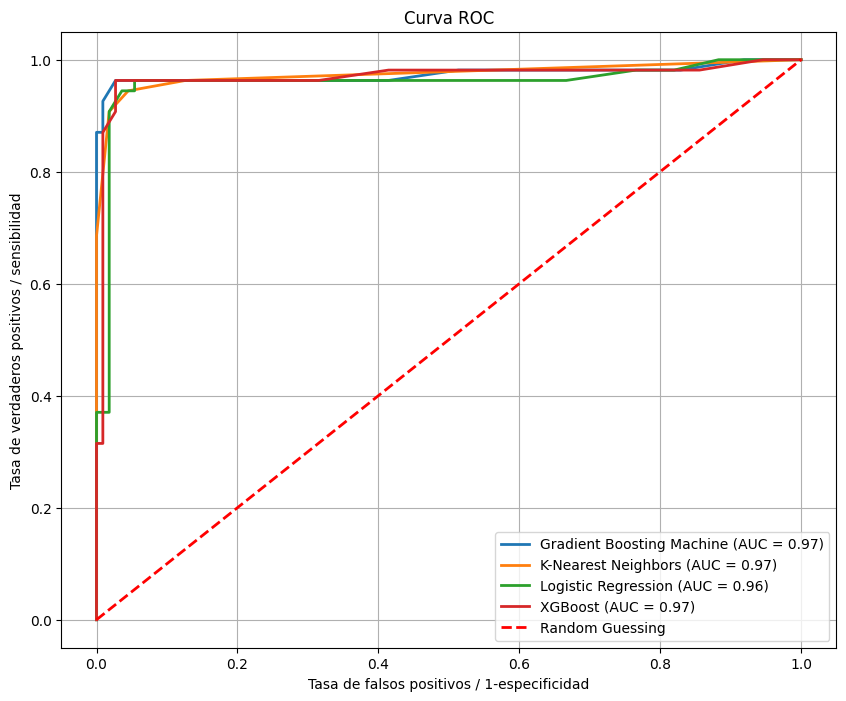

In [ ]:
from sklearn.metrics import roc_curve, auc

# Initialize figure
fig_roc = plt.figure(figsize=(10, 8))
models = ['Gradient Boosting Machine', 'K-Nearest Neighbors', 'Logistic Regression', 'XGBoost']

# Plot ROC curve for each model
for idx, model in enumerate([gbm_clf, knn_clf, model_lr, model_xgb]):
    if model == knn_clf:
        y_scores = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1], pos_label=1)
    else:
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label=1)

    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{models[idx]} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guessing')

# Set plot labels and title
plt.xlabel('Tasa de falsos positivos / 1-especificidad')
plt.ylabel('Tasa de verdaderos positivos / sensibilidad')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()

# Show plot
plt.show()


Punto ideal:  esquina superior izquierda del gráfico, es decir  una tasa de falsos positivos de cero y una tasa de verdaderos positivo de uno.

Modelos con mejor desempeño (precisión): ***Modelos gradient boosting y XGBoost***

In [ ]:
import pickle
with open("Model_Prediction.sav", "wb") as f:
    pickle.dump(model_xgb,f)

In [ ]:
with open('preprocessor.sav', 'wb') as f:
    pickle.dump(preprocessor, f)

In [ ]:

# # Load the saved model
# model_xgb = joblib.load('model_xgb.pkl')

# # Load label encoders for categorical variables
# label_encoder = LabelEncoder()

# # Function to handle user input
# def get_user_input():
#     # Example user input (you can modify this based on your actual input method)
#     user_data = {}

#     # Accepting user input dynamically
#     print("Please enter the following information:")

#     user_data['Gender'] = input("Gender (Male/Female): ").strip()
#     user_data['Age'] = int(input("Age: ").strip())
#     user_data['Occupation'] = input("Occupation: ").strip()
#     user_data['Sleep Duration'] = int(input("Sleep Duration (hours): ").strip())
#     user_data['Quality of Sleep'] = int(input("Quality of Sleep (1-10): ").strip())
#     user_data['Physical Activity Level'] = int(input("Physical Activity Level (minutes): ").strip())
#     user_data['Stress Level'] = int(input("Stress Level (1-10): ").strip())
#     user_data['BMI Category'] = input("BMI Category: ").strip()
#     user_data['Blood Pressure'] = input("Blood Pressure (Systolic/Diastolic): ").strip()
#     user_data['Heart Rate'] = int(input("Heart Rate (bpm): ").strip())
#     user_data['Daily Steps'] = int(input("Daily Steps: ").strip())

#     # Convert user input to DataFrame for consistency
#     user_df = pd.DataFrame([user_data])

#     # Apply label encoding to categorical columns
#     cat_cols=['Gender','Occupation','BMI Category']
#     for col in cat_cols:
#         user_df[col] = label_encoder.fit_transform(user_df[col])

#     # Split the 'Blood Pressure' column into two columns
#     user_df[['Systolic BP', 'Diastolic BP']] = user_df['Blood Pressure'].str.split('/', expand=True)

#     # Convert the new columns to numeric type
#     user_df[['Systolic BP', 'Diastolic BP']] = user_df[['Systolic BP', 'Diastolic BP']].apply(pd.to_numeric)

#     # Drop the original 'Blood Pressure' column
#     user_df = user_df.drop('Blood Pressure', axis=1)

#     return user_df

# # Get user input
# user_df = get_user_input()

# # Predict sleep disorder class
# predicted_class = model_xgb.predict(user_df)

# # Map numerical prediction back to original classes
# sleep_disorder_map = {0: 'No Disorder', 1: 'Sleep Apnea', 2: 'Insomnia'}
# predicted_class_label = sleep_disorder_map[predicted_class[0]]

# print(f"Predicted Sleep Disorder: {predicted_class_label}")